In [1]:
import os

# Change to the parent directory
os.chdir('../..')

# Verify the path using getcwd()
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1


In [2]:
import deepSI
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.model_fitting import fit_and_plot_cycle
import src.plotting as ptt
from src.file_loader import load_csv_files
from src.model_fitting import fit_and_plot_cycle
from src.model import arx_model
import src.sysid_util as sid
import scipy as sp
import control as ct

c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\env_analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# List of file names
file_names = [
    '9171_20240927_N11507060127_ Rapid polarization.csv',
    '9171_20240927_N11507060127_Rapid polarization-1.csv',
    '9171_20241001_N11507060127_ Rapid polarization-2.csv'
    ]

# print(f"Processing file: {file_names}")
dataframes = load_csv_files(file_names, '', 'deep learning assignment')


In [4]:
# Display the first 5 rows of each DataFrame
for key, df in dataframes.items():
    print(f"Head of DataFrame {key}:")
    print(df.head(5))
    print("\n")

Head of DataFrame 9171_20240927_N11507060127__Rapid_polarization_csv:
  Time (HH:mm:ss.SSS)    Channel   CH      V      A
0        11:51:33.361  0.9150142  CH1  1.415  0.046
1        11:51:33.597   1.151406  CH1  1.438  0.046
2        11:51:33.834  1.3879028  CH1   1.45  0.046
3        11:51:34.056  1.6098408  CH1  1.457  0.046
4        11:51:34.291  1.8455329  CH1  1.462  0.046


Head of DataFrame 9171_20240927_N11507060127_Rapid_polarization-1_csv:
  Time (HH:mm:ss.SSS)    Channel   CH      V      A
0        12:37:34.923  0.7860418  CH1   1.29  0.045
1        12:37:35.159  1.0221781  CH1  1.319  0.045
2        12:37:35.393  1.2562979  CH1  1.346  0.045
3        12:37:35.628  1.4910408  CH1  1.373  0.045
4        12:37:35.863  1.7256911  CH1    1.4  0.045


Head of DataFrame 9171_20241001_N11507060127__Rapid_polarization-2_csv:
  Time (HH:mm:ss.SSS)    Channel   CH      V      A
0        11:45:54.513   0.780562  CH1  1.429  0.046
1        11:45:54.753  1.0206133  CH1  1.444  0.046
2  

The size of 9171_20240927_N11507060127__Rapid_polarization_csv is: 9831 rows and 5 columns.


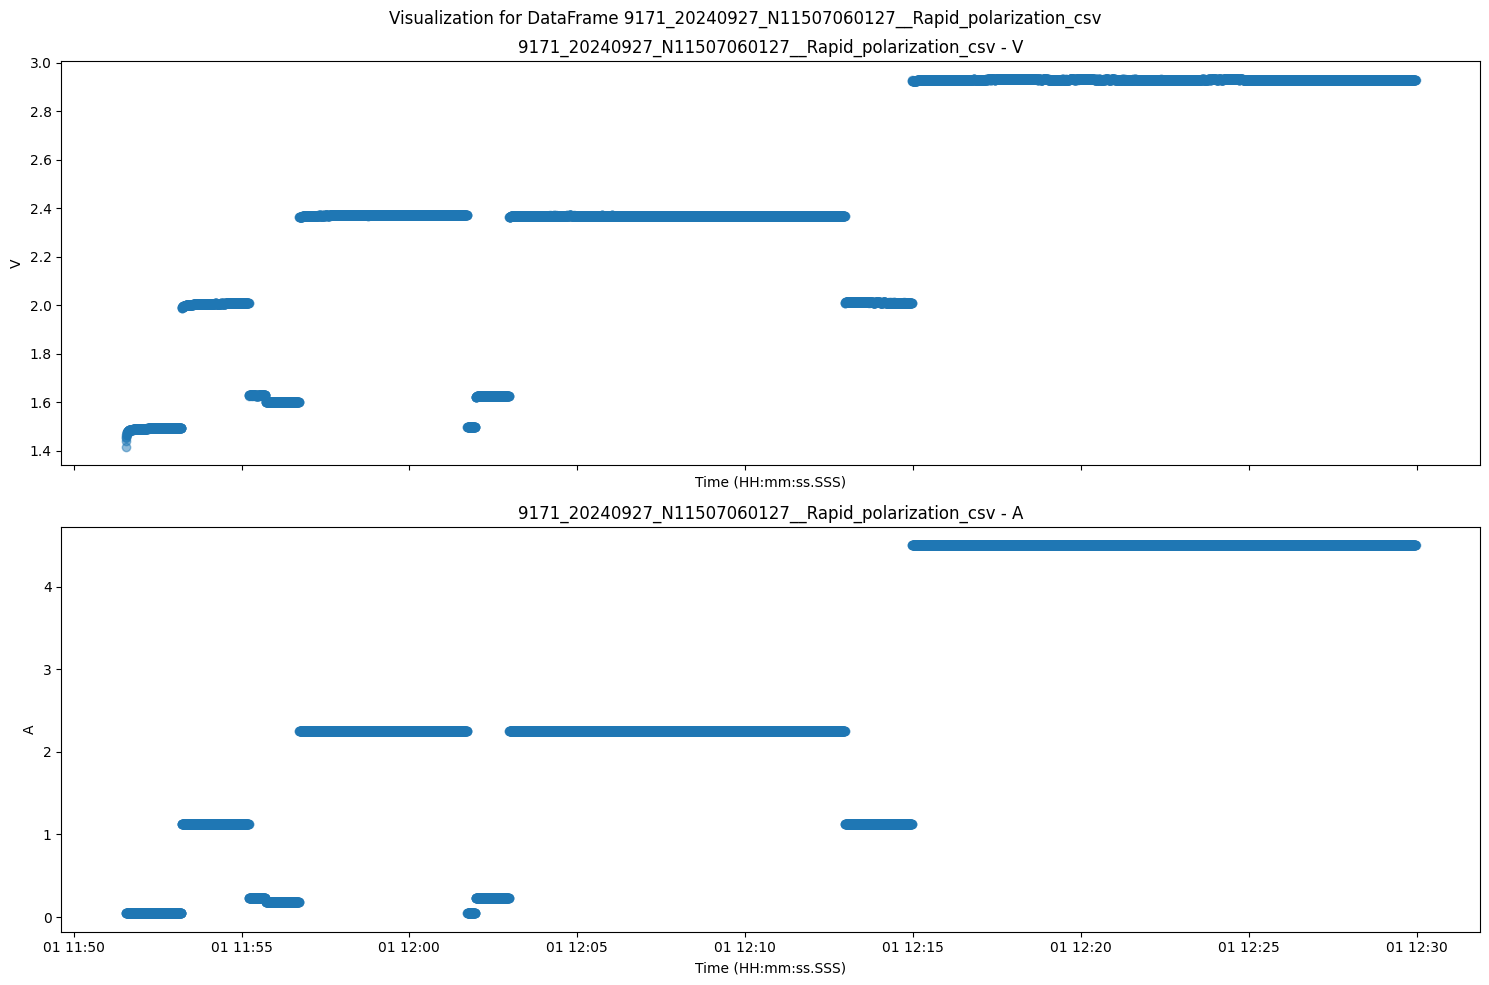

The size of 9171_20240927_N11507060127_Rapid_polarization-1_csv is: 15293 rows and 5 columns.


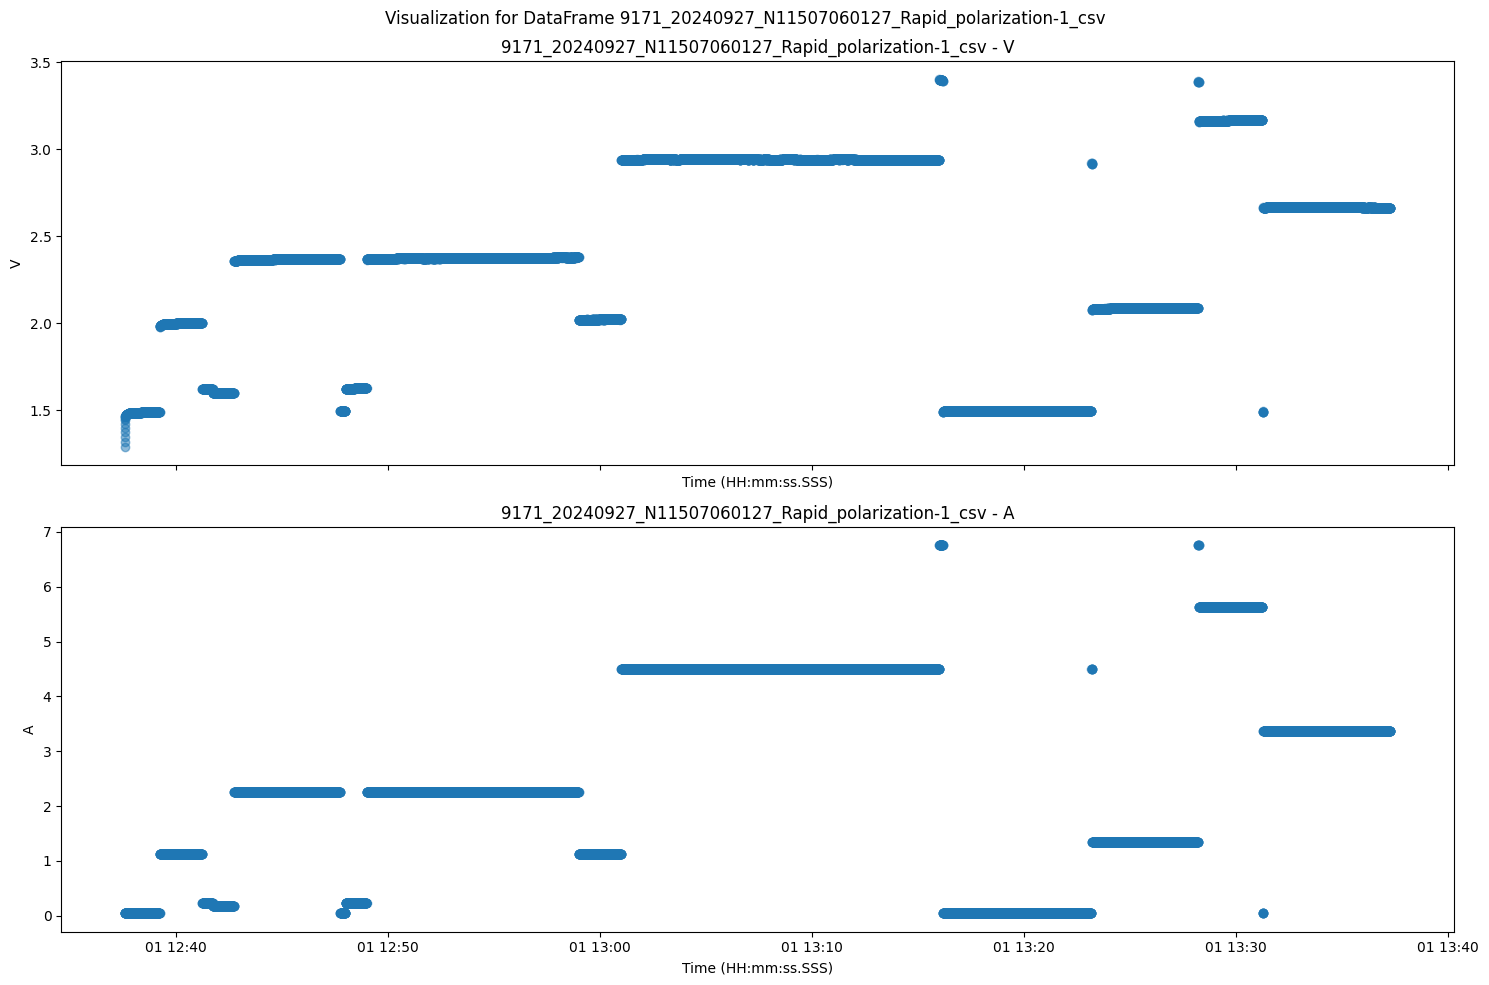

The size of 9171_20241001_N11507060127__Rapid_polarization-2_csv is: 16383 rows and 5 columns.


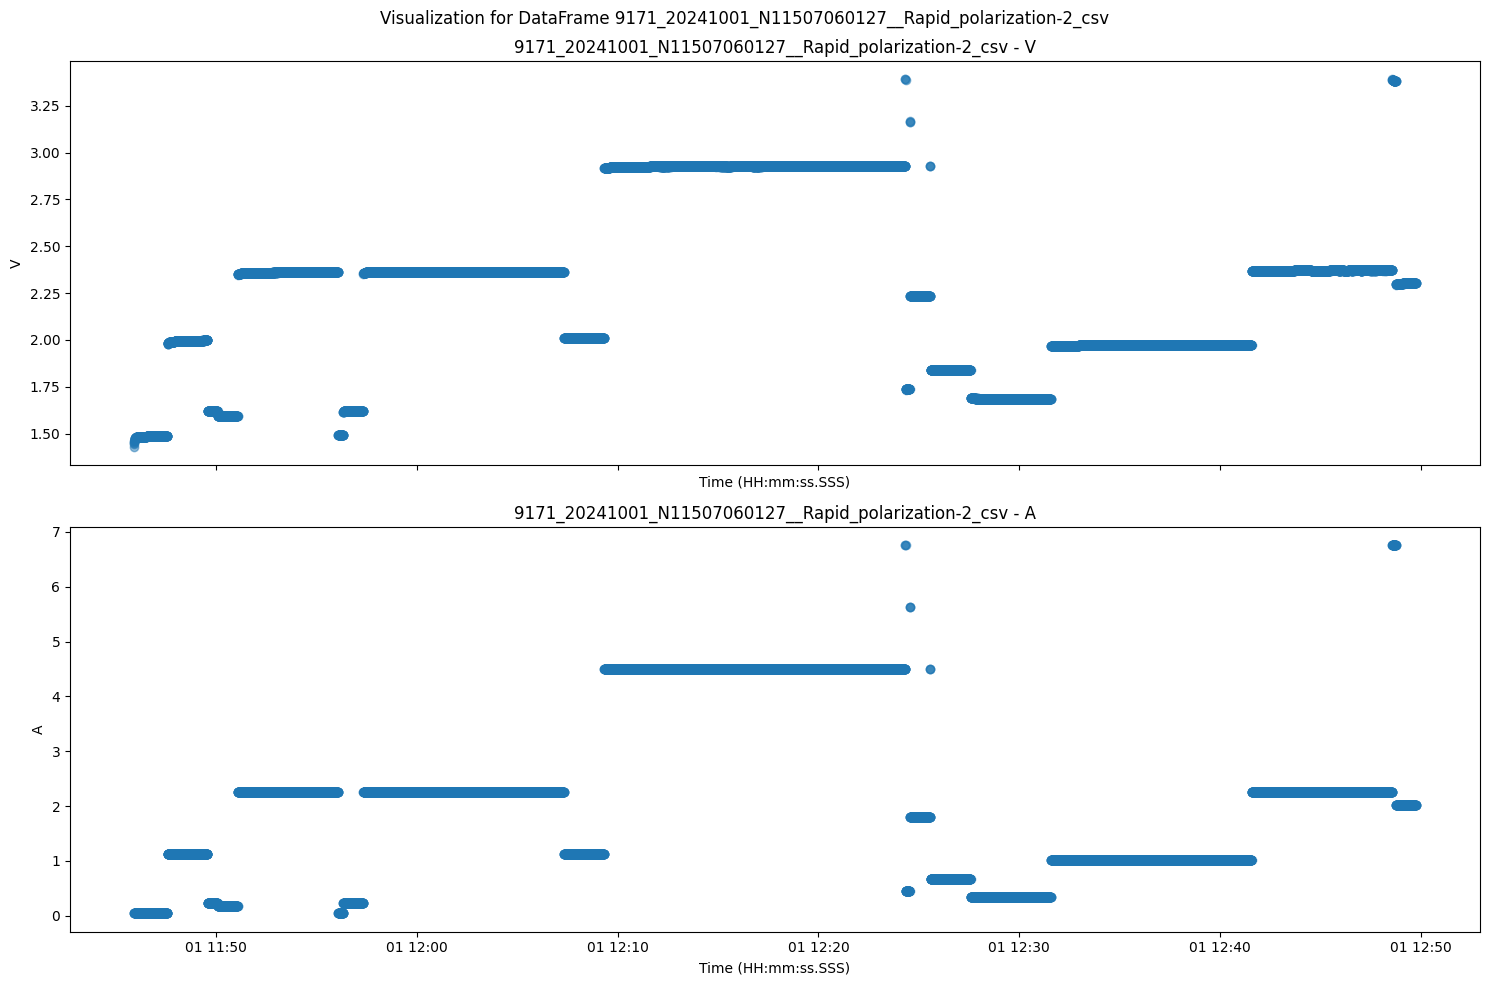

In [ ]:
# Constants
TIME_COLUMN_NAME = 'Time (HH:mm:ss.SSS)'

# Create plots for each DataFrame
for key, df in dataframes.items():
    # Check DataFrame size before processing
    print(f"The size of {key} is: {df.shape[0]} rows and {df.shape[1]} columns.")
    
    
    # Convert TIME_COLUMN_NAME to datetime with explicit format
    # try:
    #     df[TIME_COLUMN_NAME] = pd.to_datetime(df[TIME_COLUMN_NAME], format='%H:%M:%S.%f', errors='coerce')
    #     if df[TIME_COLUMN_NAME].isnull().any():
    #         invalid_rows = df[df[TIME_COLUMN_NAME].isnull()]
    #         print(f"Warning: {invalid_rows.shape[0]} rows in {key} have invalid time formats and were set to NaT.")
    # except Exception as e:
    #     print(f"Error converting time in {key}: {e}")
    #     continue
    df[TIME_COLUMN_NAME] = pd.to_datetime(df[TIME_COLUMN_NAME], format='%H:%M:%S.%f', errors='coerce')
    
    # Ensure 'Channel', 'V', and 'A' are numeric
    df[['Channel', 'V', 'A']] = df[['Channel', 'V', 'A']].apply(pd.to_numeric, errors='coerce')
    
    # Plotting setup
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)
    fig.suptitle(f"Visualization for DataFrame {key}")
    
    # Scatter plots using plot_scatterplot_on_ax
    # ptt.plot_scatterplot_on_ax(axs[0], df[TIME_COLUMN_NAME], df['Channel'], x_label=TIME_COLUMN_NAME, y_label='Channel', title=f"{key} - Channel")
    ptt.plot_scatterplot_on_ax(axs[0], df[TIME_COLUMN_NAME], df['V'], x_label=TIME_COLUMN_NAME, y_label='V', title=f"{key} - V")
    ptt.plot_scatterplot_on_ax(axs[1], df[TIME_COLUMN_NAME], df['A'], x_label=TIME_COLUMN_NAME, y_label='A', title=f"{key} - A")
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


In [6]:
# # Merge all DataFrames into one
# merged_df = pd.concat(dataframes.values(), ignore_index=True)

# # Convert 'Time (HH:mm:ss.SSS)' to datetime if it's not already
# merged_df['Time (HH:mm:ss.SSS)'] = pd.to_datetime(merged_df['Time (HH:mm:ss.SSS)'], format='%H:%M:%S.%f', errors='coerce')

# # Sort by 'Time (HH:mm:ss.SSS)'
# merged_df.sort_values(by='Time (HH:mm:ss.SSS)', inplace=True)

# # Calculate the time difference between consecutive points and store in deltaT
# merged_df['deltaT'] = merged_df['Time (HH:mm:ss.SSS)'].diff().dt.total_seconds()

# # Plot the filtered data using plot_scatterplot_on_ax
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

# ptt.plot_scatterplot_on_ax(ax1, merged_df['Time (HH:mm:ss.SSS)'], merged_df['V'], x_label='Time (HH:mm:ss.SSS)', y_label='V', title='V vs Time')
# ptt.plot_scatterplot_on_ax(ax2, merged_df['Time (HH:mm:ss.SSS)'], merged_df['A'], x_label='Time (HH:mm:ss.SSS)', y_label='A', title='A vs Time')
# ptt.plot_scatterplot_on_ax(ax3, merged_df['Time (HH:mm:ss.SSS)'], merged_df['deltaT'], x_label='Time (HH:mm:ss.SSS)', y_label='deltaT (seconds)', title='deltaT vs Time')

# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# print(f"V data has {len(merged_df['V'])} data points.")

# # # Check if all deltaT values are the same
# # all_same = merged_df['deltaT'].dropna().nunique() == 1
# # print(f"All deltaT values are the same: {all_same}")
